In [1]:
import pandas as pd
import numpy as np
import cv2
import os
import re

import torchvision.transforms.functional as FT


from PIL import Image

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from torchvision.ops.boxes import box_iou
from collections import defaultdict

import torch
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler

from matplotlib import pyplot as plt

import torchvision.transforms.functional as FT

from torch.utils.data import Dataset
#from utils import region_shape_attributes_to_xywh, transform, resize
from torchvision import transforms
from albumentations.pytorch import ToTensor
import pandas as pd
import numpy as np
from PIL import Image
import glob
import json
import torch
import cv2
import os
import albumentations
from albumentations.pytorch.transforms import ToTensorV2,ToTensor
# this function will take the dataframe and vertically stack the image ids
# with no bounding boxes
from albumentations import (ToFloat,
    CLAHE, RandomRotate90, Transpose, ShiftScaleRotate, Blur, OpticalDistortion,
    GridDistortion, HueSaturationValue, IAAAdditiveGaussianNoise, GaussNoise, MotionBlur,
    MedianBlur, IAAPiecewiseAffine, IAASharpen, IAAEmboss, RandomContrast, RandomBrightness,
    Flip, OneOf, Compose
)

from albumentations import (HorizontalFlip, ShiftScaleRotate, VerticalFlip, Normalize,Flip,
                            Compose, GaussNoise)
import torchvision.transforms.functional as FT
import xml.etree.ElementTree as ET
#from engine import train_one_epoch, evaluate
import torch
import random
from torchvision import *
import json
import os
import numpy as np
from collections import defaultdict
import numpy as np
import torch
from torchvision.ops.boxes import box_iou
import cv2
from datasets import *
import torchvision
import matplotlib.pyplot as plt
import os
import time
import shutil
from utils import *
from datasets import *
import albumentations
from albumentations import *
from matplotlib import patches
DIR_INPUT = '/media/jake/mark-4tb3/input/datasets/ballon_datasets/'
DIR_TRAIN = f'{DIR_INPUT}'
DIR_TEST = f'{DIR_INPUT}'

In [2]:
def process_bbox(df):
    df['bbox'] = df['region_shape_attributes'].apply(lambda x: eval(x))
    df['x'] = df['bbox'].apply(lambda x: x['x'])
    df['y'] = df['bbox'].apply(lambda x: x['y'])
    df['w'] = df['bbox'].apply(lambda x: x['width'])
    df['h'] = df['bbox'].apply(lambda x: x['height'])
    df['x'] = df['x'].astype(np.float)
    df['y'] = df['y'].astype(np.float)
    df['w'] = df['w'].astype(np.float)
    df['h'] = df['h'].astype(np.float)

    df.drop(columns=['bbox'], inplace=True)
    #     df.reset_index(drop=True)
    return df

In [3]:
DIR_INPUT

'/media/jake/mark-4tb3/input/datasets/ballon_datasets/'

In [4]:
df = pd.read_csv(DIR_INPUT + 'train.csv')
df.shape
input_size= 300

In [5]:
df = process_bbox(df)

In [6]:
df

,#filename,file_size,file_attributes,region_count,region_id,region_shape_attributes,region_attributes,x,y,w,h
0,34020010494_e5cb88e1c4_k.jpg,1115004,{},1,0,"{""name"":""rect"",""x"":1008,""y"":626,""width"":433,""h...",{},1008.0,626.0,433.0,526.0
1,25899693952_7c8b8b9edc_k.jpg,814535,{},1,0,"{""name"":""rect"",""x"":133,""y"":114,""width"":684,""he...",{},133.0,114.0,684.0,854.0
2,24362039530_b151b41a52_k.jpg,708540,{},1,0,"{""name"":""rect"",""x"":577,""y"":490,""width"":344,""he...",{},577.0,490.0,344.0,418.0
3,18849792632_aad23ad513_k.jpg,522255,{},10,0,"{""name"":""rect"",""x"":543,""y"":363,""width"":334,""he...",{},543.0,363.0,334.0,442.0
4,18849792632_aad23ad513_k.jpg,522255,{},10,1,"{""name"":""rect"",""x"":286,""y"":649,""width"":370,""he...",{},286.0,649.0,370.0,353.0
...,...,...,...,...,...,...,...,...,...,...,...
239,120853323_d4788431b9_b.jpg,385195,{},18,15,"{""name"":""rect"",""x"":156,""y"":8,""width"":164,""heig...",{},156.0,8.0,164.0,94.0
240,120853323_d4788431b9_b.jpg,385195,{},18,16,"{""name"":""rect"",""x"":351,""y"":130,""width"":138,""he...",{},351.0,130.0,138.0,135.0
241,120853323_d4788431b9_b.jpg,385195,{},18,17,"{""name"":""rect"",""x"":806,""y"":272,""width"":184,""he...",{},806.0,272.0,184.0,192.0
242,53500107_d24b11b3c2_b.jpg,104355,{},2,0,"{""name"":""rect"",""x"":600,""y"":381,""width"":127,""he...",{},600.0,381.0,127.0,113.0


# dataset 

In [7]:
def make_true_boxes_new_scale(df, image_num,input_size):
    #print('make_true_boxes_new_scale[B]')
    x = df[df['#filename'] == df['#filename'][image_num]]['x'].values
    y = df[df['#filename'] == df['#filename'][image_num]]['y'].values
    w = df[df['#filename'] == df['#filename'][image_num]]['w'].values
    h = df[df['#filename'] == df['#filename'][image_num]]['h'].values

    # print(x,y,w,h)
    true_boxes = []
    for i in range(len(x)):
        new_x = x[i] * (input_size / w[i])
        new_y = y[i] * (input_size / h[i])
        new_w = input_size
        new_h = input_size
        true_boxes.append([(x[i] * (input_size / w[i])),
                           y[i] * (input_size / h[i]),
                           (x[i] * (input_size / w[i])) + (input_size),
                           (y[i] * (input_size / h[i])) + (input_size)]
                          )

    true_boxes
    return torch.tensor(true_boxes)

def make_input_image(img_path,input_size):
    image_arr = cv2.imread(img_path, cv2.IMREAD_COLOR)
    image_arr = cv2.cvtColor(image_arr, cv2.COLOR_BGR2RGB).astype(np.float32)
    image_arr /= 255.0
    new_image = image_arr

    new_image = FT.to_tensor(new_image)
    new_image = FT.to_pil_image(new_image)
    new_image = FT.resize(new_image, (input_size, input_size))
    new_image = FT.to_tensor(new_image)
    new_image = FT.to_pil_image(new_image)
    new_image_model = FT.to_tensor(np.array(new_image)).cuda()
    return new_image_model

def mean_average_precision(input_size):
    #input_size = 300
    batch_size = 13
    dataset_num = 83

    data_folder = '/home/jake/PycharmProjects/balloon_detection/ballon_datasets/'
    checkpoint_fpath = '/home/jake/PycharmProjects/balloon_detection/weights/best_fasterrcnn_resnet50_fpn.pth'
    valid_dataset = BalloonDataset(data_folder, split='test', dataset_num=dataset_num, input_size=input_size)
    weight_path = '/home/jake/PycharmProjects/balloon_detection/weights/best_fasterrcnn_resnet50_fpn.pth'

    csv_path = '/home/jake/PycharmProjects/balloon_detection/ballon_datasets/via_region_data_TEST_70.csv'
    path = '/home/jake/PycharmProjects/balloon_detection/ballon_datasets/TEST/'

    ##predict boxes
    valid_loader = torch.utils.data.DataLoader(
        valid_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=4,
        collate_fn=collate_fn
    )

    df = pd.read_csv(csv_path)
    df = process_bbox(df)
    image_num = 0

    image_unique = df['#filename'].unique()
    # print('image_unique->',image_unique)
    mean_precisions = []

    for img in image_unique:
        ##input image new_image_model
        # img_path = path + df['#filename'][image_num]
        img_path = path + img
        new_image_model = make_input_image(img_path, input_size=input_size)

        ##true boxes
        df[df['#filename'] == df['#filename'][image_num]]
        # input image model(new_image_model)
        image_num = df[df['#filename'] == img].index[0]
        true_boxes = make_true_boxes_new_scale(df, image_num, input_size=input_size)

        model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
        params = [p for p in model.parameters() if p.requires_grad]
        optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
        model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
        checkpoint = torch.load(weight_path)
        model.load_state_dict(checkpoint['state_dict'])
        model.cuda().eval()

        outputs = model([new_image_model])
        outputs = [{k: v.cpu() for k, v in t.items()} for t in outputs]

        boxes_pred = outputs[0]['boxes']
        confidences = outputs[0]['scores']
        threshold = 0.5

        boxes_pred = boxes_pred[confidences > threshold]
        confidences = confidences[confidences > threshold]

        confidences = list(confidences)
        box_true_scale = make_true_boxes_new_scale(df, image_num, input_size=input_size)

        score = calculate_precision(boxes_true=box_true_scale, boxes_pred=boxes_pred, confidences=confidences,threshold=0.5)
        mean_precisions.append(score)
    return np.mean(mean_precisions)
def calculate_precision(boxes_true: torch.tensor, boxes_pred: torch.tensor, confidences: list, threshold=0.5) -> float:
    """Calculates precision for GT - prediction pairs at one threshold."""

    confidences = np.array(confidences)

    # edge case for no ground truth boxes
    if boxes_true.size(1) == 0:
        return 0.

    iou = box_iou(boxes1=boxes_pred, boxes2=boxes_true)

    pr_matches = set()
    gt_matches = set()

    # for each ground truth box, get list of pred boxes it matches with
    match_candidates = (iou >= threshold).nonzero()
    GT_PR_matches = defaultdict(list)
    for PR, GT in match_candidates:
        GT_PR_matches[GT.item()].append(PR.item())

    # Find which pred matches a GT box
    for GT, PRs in GT_PR_matches.items():
        # if multiple preds match a single ground truth box,
        # select the pred with the highest confidence
        if len(PRs) > 1:
            pr_match = PRs[confidences[PRs].argsort()[-1]]
        # else only a single pred matches this GT box
        else:
            pr_match = PRs[0]

        # only if we haven't seen a pred before can we mark a PR-GT pair as TP
        # otherwise the pred matches a different GT box and this GT might instead be a FN
        if pr_match not in pr_matches:
            gt_matches.add(GT)

        pr_matches.add(pr_match)

    TP = len(pr_matches)

    pr_idx = range(iou.size(0))
    gt_idx = range(iou.size(1))

    FP = len(set(pr_idx).difference(pr_matches))
    FN = len(set(gt_idx).difference(gt_matches))

    return TP / (TP + FP + FN)


def calculate_mean_precision(boxes_true: torch.tensor, boxes_pred: torch.tensor, confidences: np.array,
                             thresholds=(0.5,)):
    """Calculates average precision over a set of thresholds"""

    precision = np.zeros(len(thresholds))

    for i, threshold in enumerate(thresholds):
        precision[i] = calculate_precision(boxes_true=boxes_true, boxes_pred=boxes_pred, confidences=confidences,
                                           threshold=threshold)
    return precision.mean()

In [8]:
def reshape_image(img,input_size):
    new_image = img

    new_image = FT.to_tensor(new_image)
    new_image = FT.to_pil_image(new_image)
    new_image = FT.resize(new_image, (input_size, input_size))
    new_image = FT.to_tensor(new_image)
    #print(new_image.type())
    new_image = FT.to_pil_image(new_image)
    #new_image_model = FT.to_tensor(np.array(new_image)).cuda()
    return np.array(new_image)

In [9]:
images = glob.glob('/media/jake/mark-4tb3/input/datasets/ballon_datasets/images/*')
images

['/media/jake/mark-4tb3/input/datasets/ballon_datasets/images/3927754171_9011487133_b.jpg',
 '/media/jake/mark-4tb3/input/datasets/ballon_datasets/images/4955354786_337a598e4a_b.jpg',
 '/media/jake/mark-4tb3/input/datasets/ballon_datasets/images/3342804367_f43682bb80_b.jpg',
 '/media/jake/mark-4tb3/input/datasets/ballon_datasets/images/7488015492_0583857ca0_k.jpg',
 '/media/jake/mark-4tb3/input/datasets/ballon_datasets/images/6483318883_21facf57cd_b.jpg',
 '/media/jake/mark-4tb3/input/datasets/ballon_datasets/images/4057490235_2ffdf7d68b_b.jpg',
 '/media/jake/mark-4tb3/input/datasets/ballon_datasets/images/5253122239_38b1e7f61c_b.jpg',
 '/media/jake/mark-4tb3/input/datasets/ballon_datasets/images/485227412_e335662bb5_b.jpg',
 '/media/jake/mark-4tb3/input/datasets/ballon_datasets/images/7308740338_591f27b631_k.jpg',
 '/media/jake/mark-4tb3/input/datasets/ballon_datasets/images/4887227769_acd2e6127d_b.jpg',
 '/media/jake/mark-4tb3/input/datasets/ballon_datasets/images/5555705118_3390d70a

In [10]:
image = images[0]
image_arr = cv2.imread(image, cv2.IMREAD_COLOR)
image_arr = cv2.cvtColor(image_arr, cv2.COLOR_BGR2RGB).astype(np.float32)
new_image = FT.to_tensor(image_arr)
new_image = FT.to_pil_image(new_image)
new_image = FT.resize(new_image, (300, 300))
new_image = FT.to_tensor(new_image)
print(new_image.type())
new_image = FT.to_pil_image(new_image)
new_image = np.array(new_image)
#print(new_image.type())

torch.FloatTensor


In [11]:
def transform(image, boxes,split,input_size,labels):

    assert split in {'TRAIN', 'TEST'}

    # print('transform_before_boxes->',boxes)
    # Mean and standard deviation of ImageNet data that our base VGG from torchvision was trained on
    # see: https://pytorch.org/docs/stable/torchvision/models.html
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]

    #ig, ax = plt.subplots(1, 2, figsize=(24, 24))
    #ax = ax.flatten()

    new_image = image
    new_boxes = boxes
    # Skip the following operations for evaluation/testing
    if split == 'TRAIN':
        # A series of photometric distortions in random order, each with 50% chance of occurrence, as in Caffe repo
        if random.random() <0.5:
            new_image = photometric_distort(new_image)

        # Convert PIL image to Torch tensor
        new_image = FT.to_tensor(new_image)

        # Expand image (zoom out) with a 50% chance - helpful for training detection of small objects
        # Fill surrounding space with the mean of ImageNet data that our base VGG was trained on
        new_image = torch.as_tensor(new_image)
        boxes = torch.tensor(boxes)
        # 0.5 distort or brightness of the image
        if random.random() < 0.5:
            new_image, new_boxes = expand(new_image, boxes, filler=mean)

        # Convert Torch tensor to PIL image
        new_image = FT.to_pil_image(new_image)

        # Flip image with a 50% chance
        #if random.random() < 0.5:
        #    new_image, new_boxes = flip(new_image, new_boxes)

        #HorizontalFlip
        #if random.random() < 0.5:
        try:
                #print('aug_result->',aug_result)
            if random.random() < 0.3:
                if random.random() < 0.3:
                    augment = albumentations.HorizontalFlip(p=1)
                    aug = albumentations.Compose([augment],
                                                 bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})
                    aug_result = aug(image=np.array(new_image), bboxes=new_boxes, labels=labels)
                    new_image = aug_result['image']
                    new_boxes = aug_result['bboxes']
                    new_image = FT.to_pil_image(new_image)
                if random.random() < 0.3:
                    augment = albumentations.HorizontalFlip(p=0.8)
                    aug = albumentations.Compose([augment],
                                                 bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})
                    aug_result = aug(image=np.array(new_image), bboxes=new_boxes, labels=labels)
                    new_image = aug_result['image']
                    new_boxes = aug_result['bboxes']
                    new_image = FT.to_pil_image(new_image)
                if random.random() < 0.3:
                    augment = albumentations.HorizontalFlip(p=0.2)
                    aug = albumentations.Compose([augment],
                                                 bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})
                    aug_result = aug(image=np.array(new_image), bboxes=new_boxes, labels=labels)
                    new_image = aug_result['image']
                    new_boxes = aug_result['bboxes']
                    new_image = FT.to_pil_image(new_image)
                # print('aug_result->',aug_result)
            if random.random() < 0.3:
                if random.random() < 0.3:
                    augment = albumentations.ToGray(p=1)
                    aug = albumentations.Compose([augment],
                                                 bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})
                    aug_result = aug(image=np.array(new_image), bboxes=new_boxes, labels=labels)
                    new_image = aug_result['image']
                    new_boxes = aug_result['bboxes']
                    new_image = FT.to_pil_image(new_image)
                    # print('aug_result->',aug_result)
                if random.random() < 0.3:
                    augment = albumentations.ToGray(p=0.6)
                    aug = albumentations.Compose([augment],
                                                 bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})
                    aug_result = aug(image=np.array(new_image), bboxes=new_boxes, labels=labels)
                    new_image = aug_result['image']
                    new_boxes = aug_result['bboxes']
                    new_image = FT.to_pil_image(new_image)
                    # print('aug_result->',aug_result)
                if random.random() < 0.3:
                    augment = albumentations.ToGray(p=0.9)
                    aug = albumentations.Compose([augment],
                                                 bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})
                    aug_result = aug(image=np.array(new_image), bboxes=new_boxes, labels=labels)
                    new_image = aug_result['image']
                    new_boxes = aug_result['bboxes']
                    new_image = FT.to_pil_image(new_image)
                    # print('aug_result->',aug_result)
            if random.random() < 0.3:
                if random.random() < 0.3:
                    augment = albumentations.RandomBrightnessContrast(p=1)
                    aug = albumentations.Compose([augment],
                                                 bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})
                    aug_result = aug(image=np.array(new_image), bboxes=new_boxes, labels=labels)
                    new_image = aug_result['image']
                    new_boxes = aug_result['bboxes']
                    new_image = FT.to_pil_image(new_image)
                    # print('aug_result->',aug_result)
                if random.random() < 0.3:
                    augment = albumentations.RandomBrightnessContrast(p=0.2)
                    aug = albumentations.Compose([augment],
                                                 bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})
                    aug_result = aug(image=np.array(new_image), bboxes=new_boxes, labels=labels)
                    new_image = aug_result['image']
                    new_boxes = aug_result['bboxes']
                    new_image = FT.to_pil_image(new_image)
                    # print('aug_result->',aug_result)
                if random.random() < 0.3:
                    augment = albumentations.RandomBrightnessContrast(p=0.7)
                    aug = albumentations.Compose([augment],
                                                 bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})
                    aug_result = aug(image=np.array(new_image), bboxes=new_boxes, labels=labels)
                    new_image = aug_result['image']
                    new_boxes = aug_result['bboxes']
                    new_image = FT.to_pil_image(new_image)
                    # print('aug_result->',aug_result)
            if random.random() < 0.3:
                if random.random() < 0.3:
                    augment = albumentations.VerticalFlip(p=2)
                    aug = albumentations.Compose([augment],
                                                 bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})
                    aug_result = aug(image=np.array(new_image), bboxes=new_boxes, labels=labels)
                    new_image = aug_result['image']
                    new_boxes = aug_result['bboxes']
                    new_image = FT.to_pil_image(new_image)
                    # print('aug_result->',aug_result)
                if random.random() < 0.3:
                    augment = albumentations.VerticalFlip(p=0.6)
                    aug = albumentations.Compose([augment],
                                                 bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})
                    aug_result = aug(image=np.array(new_image), bboxes=new_boxes, labels=labels)
                    new_image = aug_result['image']
                    new_boxes = aug_result['bboxes']
                    new_image = FT.to_pil_image(new_image)
                    # print('aug_result->',aug_result)
                if random.random() < 0.3:
                    augment = albumentations.VerticalFlip(p=0.2)
                    aug = albumentations.Compose([augment],
                                                 bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})
                    aug_result = aug(image=np.array(new_image), bboxes=new_boxes, labels=labels)
                    new_image = aug_result['image']
                    new_boxes = aug_result['bboxes']
                    new_image = FT.to_pil_image(new_image)
                    # print('aug_result->',aug_result)
                if random.random() < 0.3:
                    augment = albumentations.VerticalFlip(p=0.9)
                    aug = albumentations.Compose([augment],
                                                 bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})
                    aug_result = aug(image=np.array(new_image), bboxes=new_boxes, labels=labels)
                    new_image = aug_result['image']
                    new_boxes = aug_result['bboxes']
                    new_image = FT.to_pil_image(new_image)
                    # print('aug_result->',aug_result)

        except:
            pass

    # Resize image to (300, 300) - this also converts absolute boundary coordinates to their fractional form
    new_image, new_boxes = resize(new_image, new_boxes,dims=(input_size, input_size))
    # print('transform_after_boxes->', new_boxes)

    # Convert PIL image to Torch tensor
    new_image = FT.to_tensor(new_image)

    # Normalize by mean and standard deviation of ImageNet data that our base VGG was trained on
    #new_image = FT.normalize(new_image, mean=mean, std=std)
    return new_image, new_boxes

In [39]:
class BalloonDataset(Dataset):
    def __init__(self, root, split,dataset_num,input_size,transforms=None):
        self.root = root
        self.split = split
        self.images = []
        self.split = split.upper()
        self.num = dataset_num
        if self.split == 'TRAIN':
            self.csv_path = '/home/jake/PycharmProjects/balloon_detection/ballon_datasets/via_region_data_{}_{}.csv'.format(self.split,self.num)
        else:
            self.csv_path = '/home/jake/PycharmProjects/balloon_detection/ballon_datasets/via_region_data_{}_70.csv'.format(self.split)
        self.df = None
        self.input_size= input_size
        self.transforms = transforms


        #rgb_mean = (0.4914, 0.4822, 0.4465)
        #rgb_std = (0.2023, 0.1994, 0.2010)

        self.images = glob.glob(self.root +self.split +'_'+str(self.num)+'/*')

        # csv
        df = pd.read_csv(self.csv_path)
        self.df = process_bbox(df)


    def __getitem__(self, idx):
        image = self.images[idx]
        image_arr = cv2.imread(image, cv2.IMREAD_COLOR)
        image_arr = cv2.cvtColor(image_arr, cv2.COLOR_BGR2RGB).astype(np.float32)
        image_arr /= 255.0
        
        width = image_arr.shape[1]
        height = image_arr.shape[0]


        image_id = str(image.split('.')[0])
        image_id = str(image_id.split('/')[-1]) + '.jpg'

        point = self.df[self.df['#filename'] == image_id]
        boxes = point[['x', 'y', 'w', 'h']].values
        boxes[:, 2] = boxes[:, 0] + boxes[:, 2] 
        boxes[:, 3] = boxes[:, 1] + boxes[:, 3] 
        labels = torch.ones((point.shape[0],), dtype=torch.int64)

        # suppose all instances are not crowd
        iscrowd = torch.zeros((point.shape[0],), dtype=torch.int64)

        #transform resize image,boxes
        #image_arr, boxes = transform(image_arr, boxes, self.split,self.input_size,labels=labels)

        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        area = torch.as_tensor(area,dtype=torch.float32)

        target = {}
        
        image_arr = reshape_image(image_arr,input_size)
        #print('boxes->',boxes)
        #print('new_dims->',new_dims)
        #print(('old_dims->',old_dims))
        
        #boxes = FT.to_tensor(boxes)
        old_dims = torch.FloatTensor([width, height,width, height]).unsqueeze(0)
        new_dims = torch.FloatTensor([self.input_size, self.input_size,self.input_size, self.input_size]).unsqueeze(0)
        
        boxes = boxes / old_dims
        boxes = boxes * new_dims
        
        #image_arr, boxes = transform(image_arr, boxes, self.split,self.input_size,labels=labels)
        target['boxes'] = boxes
        target['labels'] = labels
        target['area'] = area
        target['iscrowd'] = iscrowd
        
        #image_arr = FT.to_pil_image(image_arr)
        #image_arr = np.array(image_arr)
        if self.transforms:
            sample = {
                #'image': FT.to_tensor(image_arr),
                #'image': FT.to_tensor(image_arr),
                'image': image_arr,
                'bboxes': target['boxes'],
                'labels': labels
            }
            #print('images->',np.array(images).shape)
            sample = self.transforms(**sample)
        
            image = sample['image']
            target['boxes'] = torch.stack(tuple(map(torch.tensor,zip(*sample['bboxes'])))).permute(1, 0)
        
        return image, target, image_id

    def __len__(self):
        # print('__len__')
        return len(self.images)


def collate_fn(batch):
    return tuple(zip(*batch))

In [40]:
# Albumentations
def get_train_transform():
    return A.Compose([
        A.Flip(0.5),
        A.ToGray(0.5),
        ToTensor()
        #ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

def get_valid_transform():
    return A.Compose([
        ToTensor()
        #ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

# Create the model

In [41]:
# load a model; pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

In [42]:
num_classes = 2  # 1 class (wheat) + background

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [43]:
class Averager:
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0

    def send(self, value):
        self.current_total += value
        self.iterations += 1

    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations

    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0

In [44]:
input_size = 300
dataset_num = 83
batch_size = 6

data_folder = '/home/jake/PycharmProjects/balloon_detection/ballon_datasets/'
train_dataset = BalloonDataset(data_folder,'train',dataset_num,input_size,get_train_transform())

# split the dataset in train and test set
indices = torch.randperm(len(train_dataset)).tolist()

train_data_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

In [45]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# sample

In [46]:
for idx,(images, targets, image_ids) in enumerate(train_data_loader):
    print("=============={}================".format(idx))
    #print(targets[0]['boxes'])

==============0================
==============1================
==============2================


ValueError: Caught ValueError in DataLoader worker process 3.
Original Traceback (most recent call last):
  File "/home/jake/venv/lib/python3.7/site-packages/torch/utils/data/_utils/worker.py", line 178, in _worker_loop
    data = fetcher.fetch(index)
  File "/home/jake/venv/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 44, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/jake/venv/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 44, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "<ipython-input-39-a069c54fe760>", line 86, in __getitem__
    sample = self.transforms(**sample)
  File "/home/jake/venv/lib/python3.7/site-packages/albumentations/core/composition.py", line 174, in __call__
    p.preprocess(data)
  File "/home/jake/venv/lib/python3.7/site-packages/albumentations/core/utils.py", line 62, in preprocess
    data[data_name] = self.check_and_convert(data[data_name], rows, cols, direction="to")
  File "/home/jake/venv/lib/python3.7/site-packages/albumentations/core/utils.py", line 70, in check_and_convert
    return self.convert_to_albumentations(data, rows, cols)
  File "/home/jake/venv/lib/python3.7/site-packages/albumentations/augmentations/bbox_utils.py", line 51, in convert_to_albumentations
    return convert_bboxes_to_albumentations(data, self.params.format, rows, cols, check_validity=True)
  File "/home/jake/venv/lib/python3.7/site-packages/albumentations/augmentations/bbox_utils.py", line 303, in convert_bboxes_to_albumentations
    return [convert_bbox_to_albumentations(bbox, source_format, rows, cols, check_validity) for bbox in bboxes]
  File "/home/jake/venv/lib/python3.7/site-packages/albumentations/augmentations/bbox_utils.py", line 303, in <listcomp>
    return [convert_bbox_to_albumentations(bbox, source_format, rows, cols, check_validity) for bbox in bboxes]
  File "/home/jake/venv/lib/python3.7/site-packages/albumentations/augmentations/bbox_utils.py", line 251, in convert_bbox_to_albumentations
    check_bbox(bbox)
  File "/home/jake/venv/lib/python3.7/site-packages/albumentations/augmentations/bbox_utils.py", line 330, in check_bbox
    "to be in the range [0.0, 1.0], got {value}.".format(bbox=bbox, name=name, value=value)
ValueError: Expected x_max for bbox (tensor(0.9297, dtype=torch.float64), tensor(0.5198, dtype=torch.float64), tensor(1.0010, dtype=torch.float64), tensor(0.7504, dtype=torch.float64), tensor(1)) to be in the range [0.0, 1.0], got 1.0009765625.


In [30]:
images, targets, image_ids = next(iter(train_data_loader))
images = list(image.to(device) for image in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

In [35]:
n = 3
boxes = targets[n]['boxes'].cpu().numpy().astype(np.int32)
sample = images[n].permute(1,2,0).cpu().numpy()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


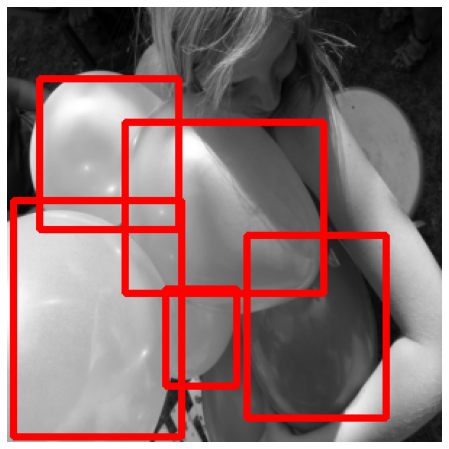

In [36]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(sample,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  (220, 0, 0), 3)
    
ax.set_axis_off()
ax.imshow(sample)

# Train

In [37]:
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
lr_scheduler = None

In [38]:
loss_hist = Averager()
itr = 1
num_epochs = 100
train_loss = []
for epoch in range(num_epochs):
    loss_hist.reset()
    
    for images, targets, image_ids in train_data_loader:
        #print('target->',targets[0])
        
        #images = list(image.type(torch.FloatTensor).to(device)for image in images)
        images = list(image.to(device)for image in images)
        #images = list(image.type('torch.FloatTensor') for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        #print('images->',np.array(images)[0].shape)
        #print('typeImages->',type(images[0]))
        #print('tensortype->',images[0].type())
        #print('targets->',targets)
        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())
        train_loss.append(losses.item())
        loss_value = losses.item()

        loss_hist.send(loss_value)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        if itr % 50 == 0:
            print(f"Iteration #{itr} loss: {loss_value}")
            score = mean_average_precision(input_size=input_size)
            print('[A]Epoch[{}] loss[{}] MAP:[{}%]'.format(epoch,epoch_train_loss,score))

        itr += 1
    
    # update the learning rate
    if lr_scheduler is not None:
        lr_scheduler.step()
    epoch_train_loss = np.mean(train_loss)

    print(f"Epoch #{epoch} loss: {loss_hist.value}")   

/home/jake/venv/lib/python3.7/site-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/pytorch/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple)


Epoch #0 loss: 0.5529275733368993
Epoch #1 loss: 0.2979841216895312
Epoch #2 loss: 0.23433536046915346
Iteration #50 loss: 0.10023179521356046
[A]Epoch[3] loss[0.36174901849852803] MAP:[0.09523809523809523%]
Epoch #3 loss: 0.1812390545982543
Epoch #4 loss: 0.15108726852730642
Epoch #5 loss: 0.1326953711294547
Epoch #6 loss: 0.11748086746987063
Iteration #100 loss: 0.09902109321464467
[A]Epoch[7] loss[0.23824994531720997] MAP:[0.09523809523809523%]
Epoch #7 loss: 0.1041403702672165
Epoch #8 loss: 0.09363140177022698
Epoch #9 loss: 0.08642994718926086
Iteration #150 loss: 0.15975934700937702
[A]Epoch[10] loss[0.19519513364471744] MAP:[0.09523809523809523%]
Epoch #10 loss: 0.08526531971517173
Epoch #11 loss: 0.08211405128023276
Epoch #12 loss: 0.09102216828468337
Epoch #13 loss: 0.10512852144479992
Iteration #200 loss: 0.048769539931732886
[A]Epoch[14] loss[0.16539152836943302] MAP:[0.09523809523809523%]
Epoch #14 loss: 0.10787355971305483
Epoch #15 loss: 0.11614988764145733
Epoch #16 los

KeyboardInterrupt: 